# Implementing a retinotopic transform using `grid_sample` from `pyTorch`

The [grid_sample](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) transform is a powerful function which allows to transform any input image into a new topology. It is notably used in [Spatial Transformer Networks](https://arxiv.org/abs/1506.02025) for instance to learn CNN to be invariant to affine transforms. We used it recently in a publication [What You See Is What You Transform: Foveated Spatial Transformers as a Bio-Inspired Attention Mechanism](https://laurentperrinet.github.io/publication/dabane-22/) by Ghassan Dabane *et al*.

The use of `grid_sample` can b etedious and here, we show how to use it to create a log-polar transform of the image and create the following figure:

![Retinotopy](../files/2023-02-02-implementing-a-retinotopic-transform-using-grid_sample-from-pytorch.png)

> A picture (extract from the painting ["The Ambassadors" by Hans Holbein the Younger](https://en.wikipedia.org/wiki/The_Ambassadors_(Holbein))) can be represented on a regular grid represented by vertical (red) and horizontal (blue) lines. Retinotopy transforms this grid, and in particular the area representing the fovea (shaded gray) is over-represented. Applied to the original image of the portrait, the image is strongly distorted and represents more finally the parts under the axis of sight (here the mouth).


<!-- TEASER_END -->

Let's first initialize the notebook :

In [1]:
import os

import numpy as np
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
import torch.nn.functional as F

import matplotlib.pyplot as plt
fig_width = 15

image_size = 257

## definition of the grid

Let's first define a first grid as a set of points defined in absolute coordinates between $-1$ and $1$, and define the corresponding meshgrid:

In [2]:
image_size_az, image_size_el = 360, 400
rs_ = torch.logspace(0, -4, image_size_az, base=2)
ts_ = torch.linspace(-torch.pi, torch.pi, image_size_el+1)[:-1]

grid_xs = torch.outer(rs_, -torch.cos(ts_)) 
grid_ys = torch.outer(rs_, torch.sin(ts_)) 
grid_xs.shape, grid_ys.shape

(torch.Size([360, 400]), torch.Size([360, 400]))

These are then formated in the right format to be used by the function:

In [3]:
center_x, center_y = 0., 0. # defines the fixation point's center in absolute coordinates
logPolar_grid = torch.stack((grid_xs-center_x, grid_ys-center_y), 2)
logPolar_grid = logPolar_grid.unsqueeze(0) # add batch dim
logPolar_grid.shape

torch.Size([1, 360, 400, 2])

In [4]:
logPolar_grid.min()

tensor(-1.)

In [5]:
# F.grid_sample?

## appication to a synthetic image

We define a synthetic image to illustrate the transform, it consists of white pixels, red verticals and blue horizontals, regularly spaced:

In [6]:
image_grid_size = 8
image_grid_tens = torch.ones((3, image_size, image_size)).float()
image_grid_tens[0:2, ::image_grid_size, :] = 0
image_grid_tens[1:3, :, ::image_grid_size] = 0
fovea_size = 5 
image_grid_tens[:, (image_size//2-image_grid_size*fovea_size):(image_size//2+image_grid_size*fovea_size), (image_size//2-image_grid_size*fovea_size):(image_size//2+image_grid_size*fovea_size)] *= .5
image_grid_tens.shape, image_grid_tens.unsqueeze(0).shape

(torch.Size([3, 257, 257]), torch.Size([1, 3, 257, 257]))

to display it, we need to transform the torch format to a numpy / matplotlib compatible one, which can be first tested on a MWE (minimal working example) using `torch.movedim`:

In [7]:
torch.movedim(torch.randn(1, 2, 3), (0, 1, 2), (1, 2, 0)).shape

torch.Size([3, 1, 2])

this can be done on the image in a few lines:

In [8]:
image_grid = image_grid_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid = torch.movedim(image_grid, (1, 2, 0), (0, 1, 2))
image_grid = image_grid.numpy()
image_grid.shape

(257, 257, 3)

so that we can display the synthetic image:

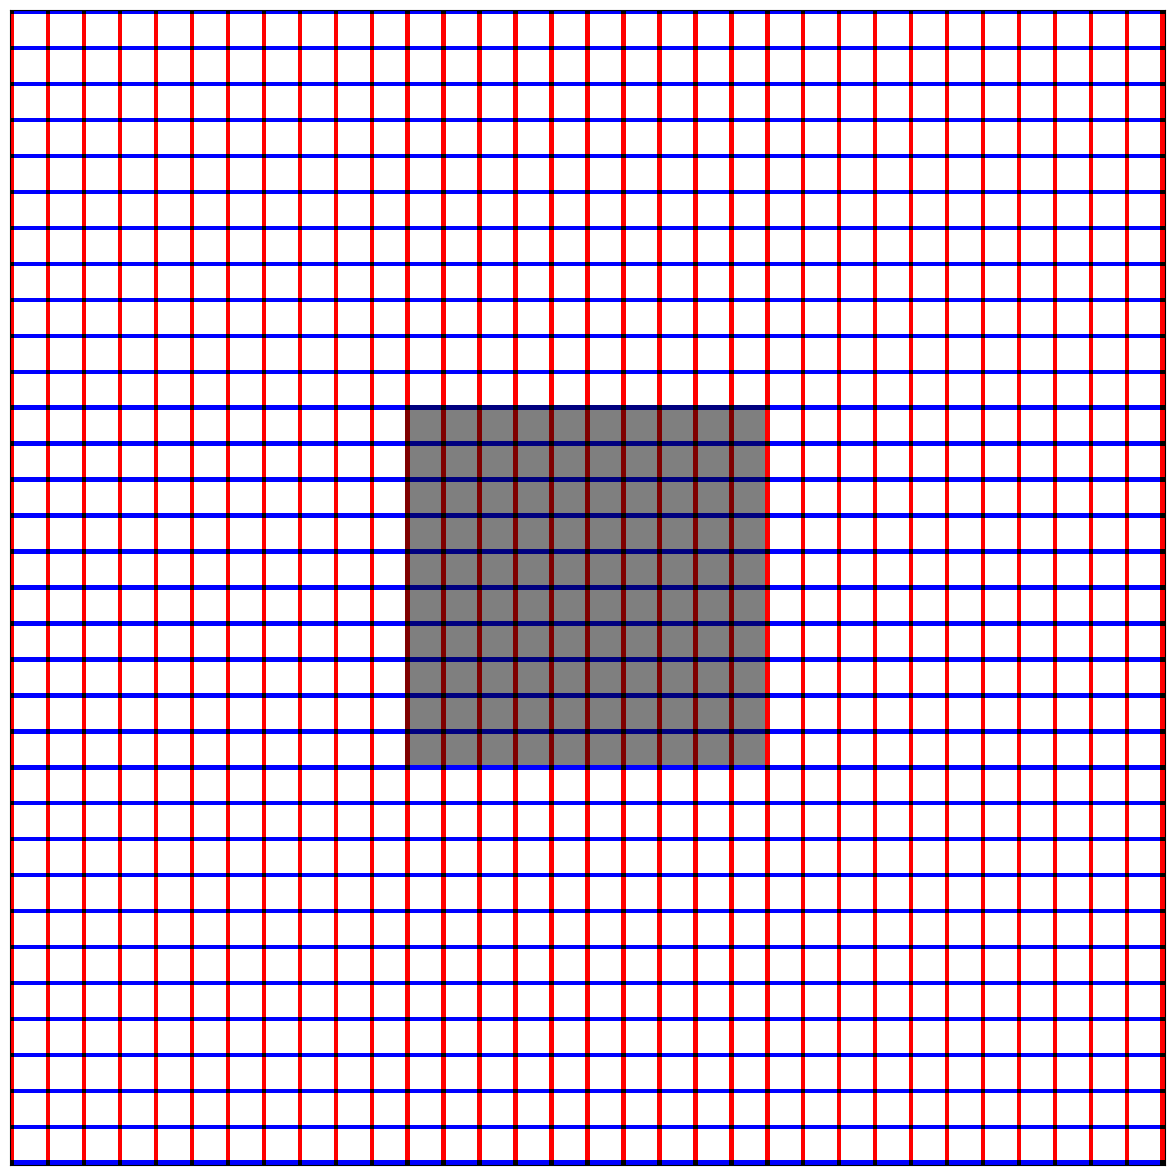

In [9]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Let's transform the image of the grid:

In [10]:
image_grid_ret_tens = F.grid_sample(image_grid_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_grid_tens.shape, logPolar_grid.shape, image_grid_ret_tens.shape

(torch.Size([3, 257, 257]),
 torch.Size([1, 360, 400, 2]),
 torch.Size([1, 3, 360, 400]))

and transform it back to numpy:

In [11]:
image_grid_ret_tens = image_grid_ret_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid_ret_tens = torch.movedim(image_grid_ret_tens, (1, 2, 0), (0, 1, 2))
image_grid_ret = image_grid_ret_tens.numpy()

image_grid_ret.shape

(360, 400, 3)

to then display the retinotopic transform of the grid image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


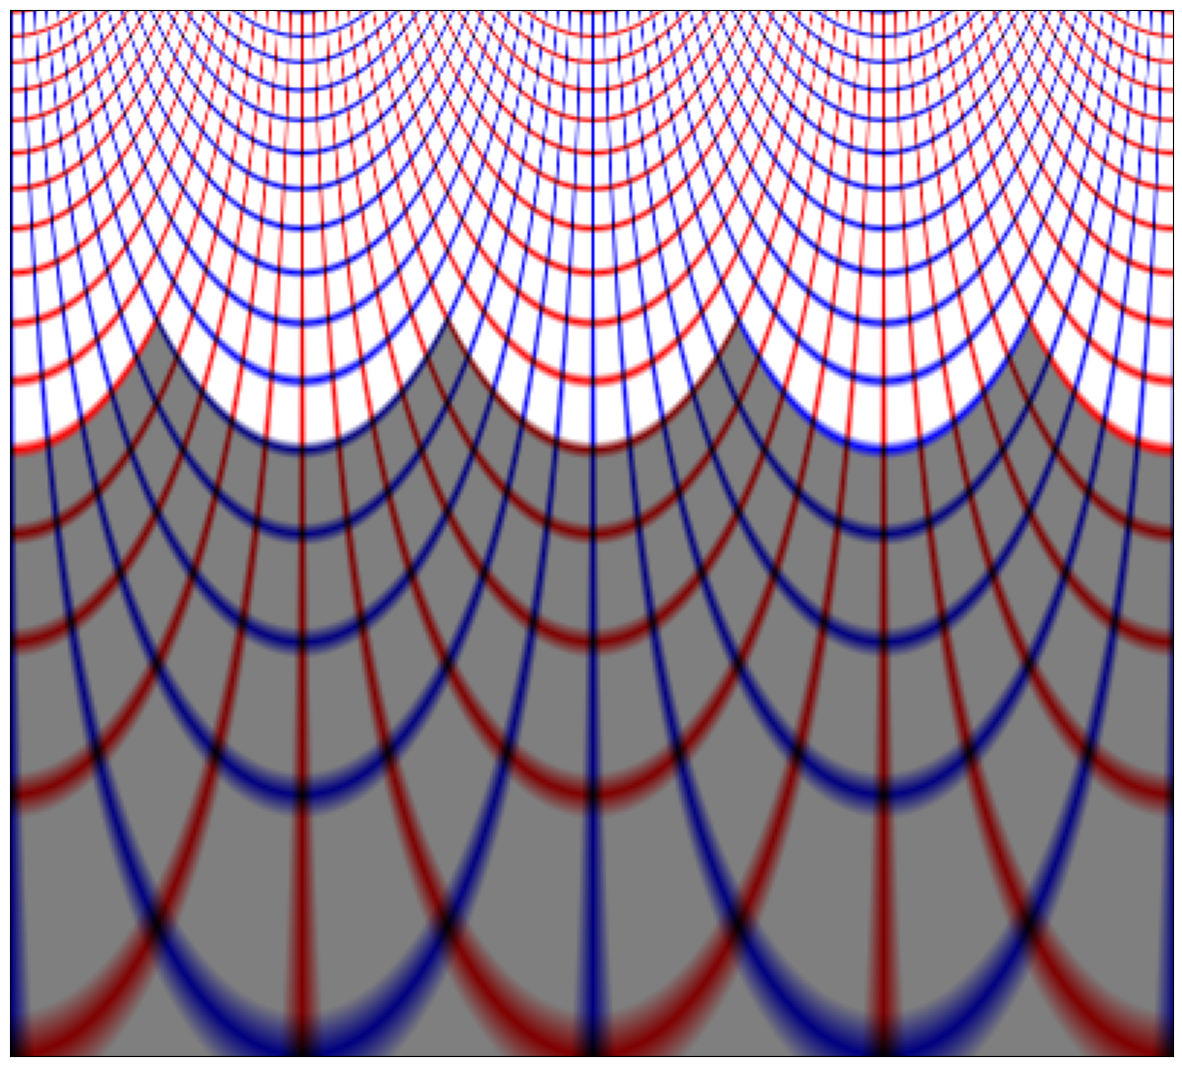

In [12]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid_ret)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

## appication to a natural image

Let's load an image by extracting a part from the painting ["The Ambassadors" by Hans Holbein the Younger](https://en.wikipedia.org/wiki/The_Ambassadors_(Holbein)):

In [13]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/8/88/Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg'
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg/608px-Hans_Holbein_the_Younger_-_The_Ambassadors_-_Google_Art_Project.jpg'
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# import imageio
import imageio.v2 as imageio

im_shift_X, im_shift_Y = 0, 27
image = imageio.imread(image_url)[im_shift_X:im_shift_X+image_size, im_shift_Y:im_shift_Y+image_size, :] / 255
image.max()

1.0

and display it:

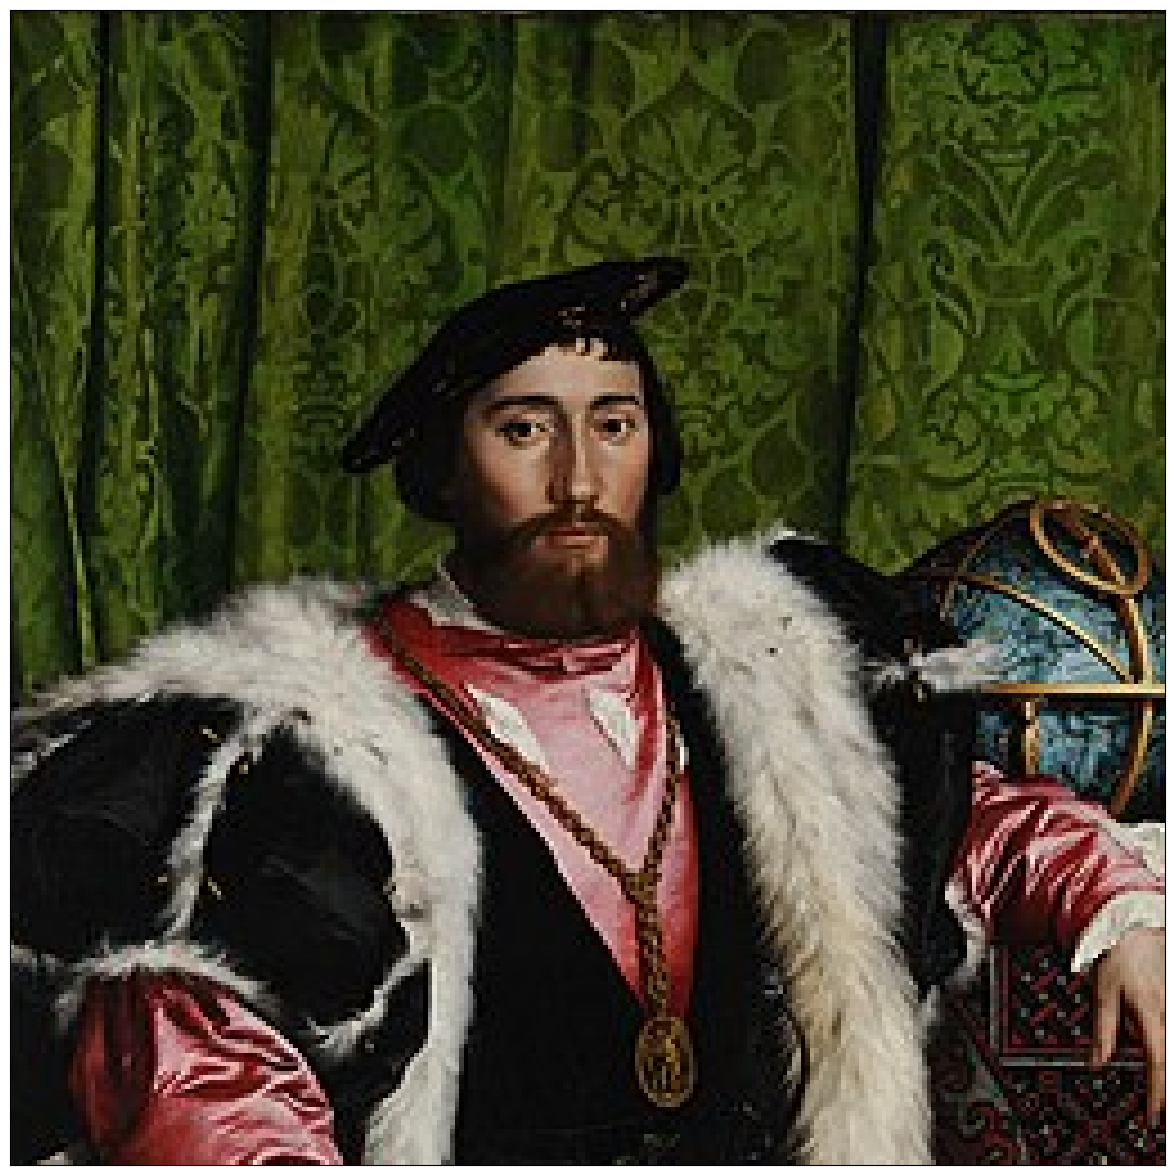

In [14]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

to use it in the function, we need to transform the numpy format to a torch compatible one, which can be first tested on a MWE (minimal working example):

In [15]:
torch.movedim(torch.randn(1, 2, 3), (1, 2, 0), (0, 1, 2)).shape

torch.Size([2, 3, 1])

this now looks like:

In [16]:
image_tens = torch.from_numpy(image)
# swap from H, W, C (numpy) to C, H, W (torch)
image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))
image.shape, image_tens.shape

((257, 257, 3), torch.Size([3, 257, 257]))

Let's transform the image:

In [17]:
image_ret_tens = F.grid_sample(image_tens.unsqueeze(0).float(), logPolar_grid, align_corners=False, padding_mode='border')
image_ret_tens.shape

torch.Size([1, 3, 360, 400])

and transform it back to numpy:

In [18]:
image_ret_tens = image_ret_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_ret_tens = torch.movedim(image_ret_tens, (1, 2, 0), (0, 1, 2))
image_ret = image_ret_tens.numpy()

and display it:

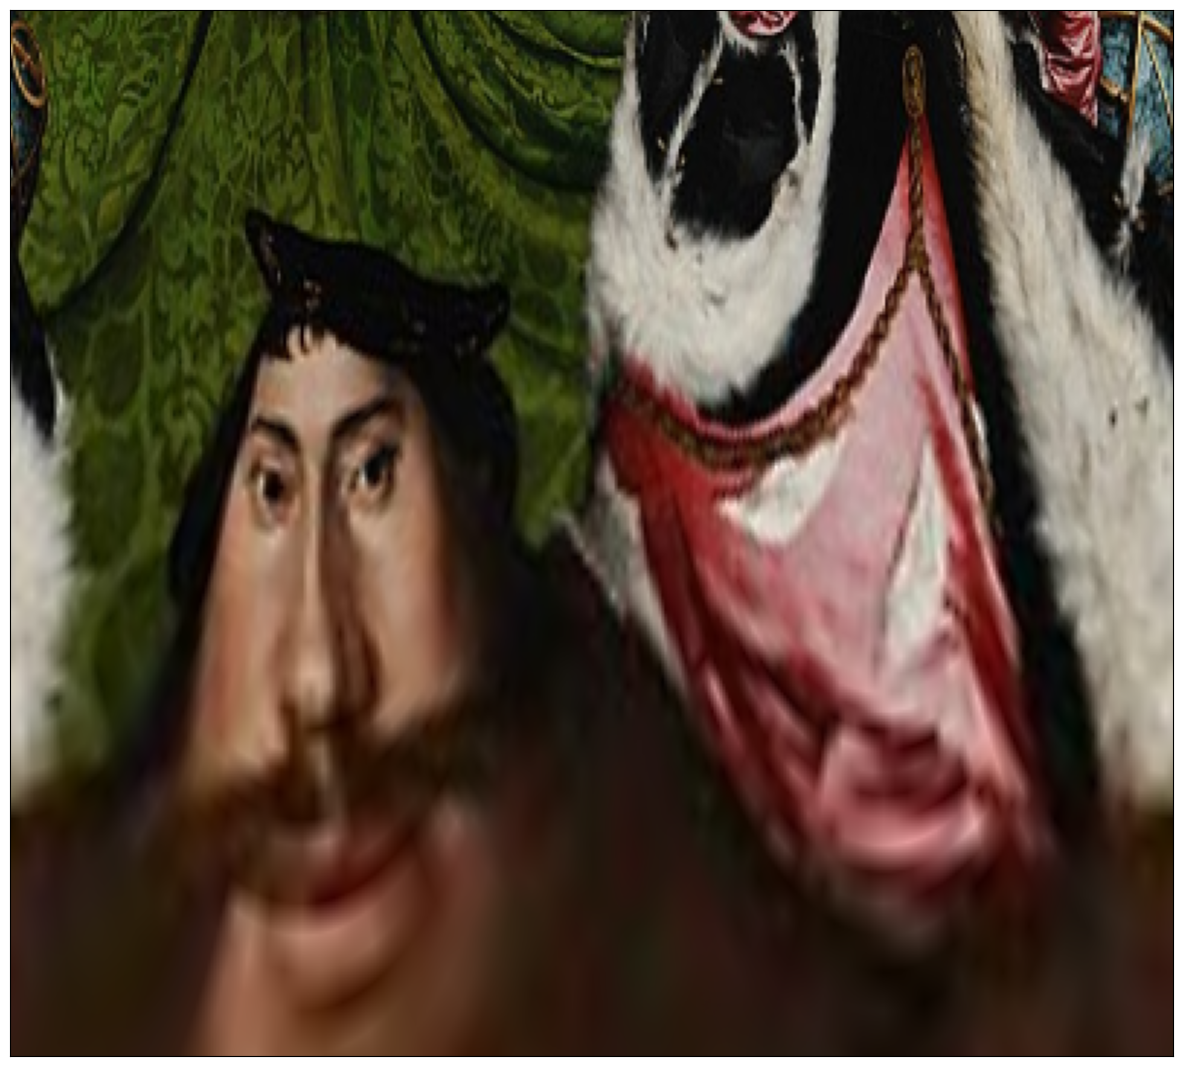

In [19]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_ret)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

## summary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


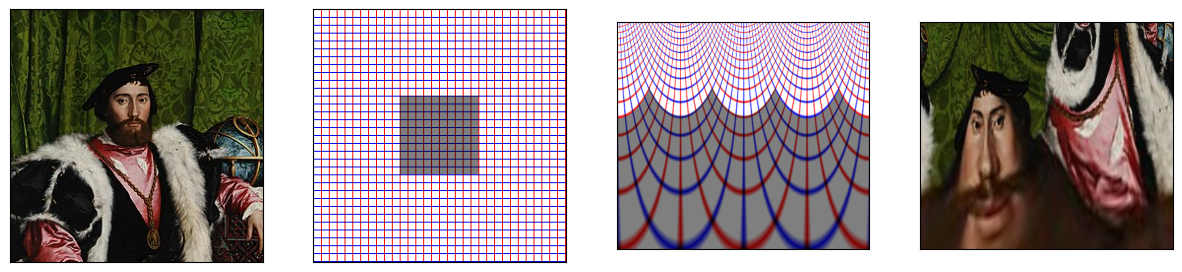

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(fig_width, fig_width))
axs[0].imshow(image)
axs[1].imshow(image_grid)
axs[2].imshow(image_grid_ret)
axs[3].imshow(image_ret)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])  
fig.set_facecolor(color='white')
fname = '../files/2023-02-02-implementing-a-retinotopic-transform-using-grid_sample-from-pytorch'
fig.savefig(fname + '.png', dpi=200, bbox_inches='tight', pad_inches=0, edgecolor=None)
# fig.savefig(fname + '_dpi800.png', dpi=800, bbox_inches='tight', pad_inches=0, edgecolor=None)
# fig.savefig(fname + '_dpi1500.png', dpi=1500, bbox_inches='tight', pad_inches=0, edgecolor=None)